In [1]:
import numpy as np
import math
from sympy.parsing.sympy_parser import parse_expr
from sympy import *
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
from qiskit.quantum_info import Pauli
import random as rd
import re
import operator
import functools
from scipy.linalg import expm, sinm, cosm
from numpy.linalg import matrix_power
from typing import Sequence, Tuple

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from cirq.contrib.svg import SVGCircuit

2023-02-02 17:52:33.171432: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-02 17:52:33.171447: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-02 17:52:34.844130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-02 17:52:34.844145: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-02 17:52:34.844155: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rafael-ThinkPad): /proc/driver/nvidia/version does not exist
2023-02-02 17:52:34.844313: I tensorflow/core/platform/cpu_fe

In [3]:
with open('3sat.dimacs', 'r') as f:
    dimacs = f.read()
print(dimacs)

c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0


In [4]:
class Verifier():
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [5]:
# Function to create the
# random binary string
def rand_key(p):
   
    # Variable to store the
    # string
    key1 = ""
 
    # Loop to find the string
    # of desired length
    for i in range(p):
         
        # randint function to generate
        # 0, 1 randomly and converting
        # the result into str
        temp = str(rd.randint(0, 1))
 
        # Concatenation the random 0, 1
        # to the final result
        key1 += temp
         
    return(key1)

In [6]:
v = Verifier('3sat.dimacs')   

In [7]:
def generate_binary_strings(bit_count):
    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')

    genbin(bit_count)
    return binary_strings

binary_strings = generate_binary_strings(3)

In [8]:
binary_strings

['000', '001', '010', '011', '100', '101', '110', '111']

In [9]:
v.is_correct(binary_strings[0])

True

In [10]:
valid_keys = []

for key in binary_strings:
    if v.is_correct(key) == True:
        print(key) 
        valid_keys.append(key)

000
011
101


In [11]:
statement = []
for line in dimacs.split('\n'):
    line = line.strip(' 0')
    clause = []
    for literal in line.split(' '):
            if literal in ['p', 'c']:
            # line is not a clause
                break
            else:
                #print(literal)
                clause.append(int(literal))
    statement.append(clause)

In [12]:
new_stat = [ele for ele in statement if ele != []]
new_stat

[[-1, -2, -3], [1, -2, 3], [1, 2, -3], [1, -2, -3], [-1, 2, 3]]

In [13]:
Z = IndexedBase('Z')
i= symbols('i', cls=Idx)

In [42]:
all_clauses = []
for i in range(len(new_stat)):
    clauses_z = []
    for literal in new_stat[i]:
        #print(literal)
        if literal < 0:
            literal_exp = 1 - Z[abs(literal)]
        else:
            literal_exp = 1 + Z[abs(literal)]
        clauses_z.append(literal_exp)
    all_clauses.append(clauses_z)

In [43]:
expanded_clause = expand(np.prod(all_clauses[0]))
expanded_clause

-Z[1]*Z[2]*Z[3] + Z[1]*Z[2] + Z[1]*Z[3] - Z[1] + Z[2]*Z[3] - Z[2] - Z[3] + 1

In [44]:
clauses_list = []
for clause in all_clauses:
    print(expand(np.prod(clause)))
    clauses_list.append(expand(np.prod(clause)))

-Z[1]*Z[2]*Z[3] + Z[1]*Z[2] + Z[1]*Z[3] - Z[1] + Z[2]*Z[3] - Z[2] - Z[3] + 1
-Z[1]*Z[2]*Z[3] - Z[1]*Z[2] + Z[1]*Z[3] + Z[1] - Z[2]*Z[3] - Z[2] + Z[3] + 1
-Z[1]*Z[2]*Z[3] + Z[1]*Z[2] - Z[1]*Z[3] + Z[1] - Z[2]*Z[3] + Z[2] - Z[3] + 1
Z[1]*Z[2]*Z[3] - Z[1]*Z[2] - Z[1]*Z[3] + Z[1] + Z[2]*Z[3] - Z[2] - Z[3] + 1
-Z[1]*Z[2]*Z[3] - Z[1]*Z[2] - Z[1]*Z[3] - Z[1] + Z[2]*Z[3] + Z[2] + Z[3] + 1


In [48]:
total_clause = np.sum(clauses_list)
total_clause_broken = Add.make_args(total_clause)
print(total_clause)

-3*Z[1]*Z[2]*Z[3] - Z[1]*Z[2] - Z[1]*Z[3] + Z[1] + Z[2]*Z[3] - Z[2] - Z[3] + 5


In [49]:
for piece in total_clause_broken:
    print(piece.atoms(Number))

{5}
{2, -1}
{3, -1}
{2, 3}
{1, 2, -1}
{1, 3, -1}
{1, 2, 3, -3}
{1}


In [45]:
crc = [] #circuit-ready clauses

for clause in all_clauses:
    circuit_ready_clause_piece = []
    expanded_clause = expand(np.prod(clause))
    clause_broken = Add.make_args(expanded_clause)
    
    for piece in clause_broken:
        if piece == 1:
            circuit_ready_clause_piece.append('id')
        else: 
            atom_list = list(piece.atoms(Number))
            #print(atom_list)
            if atom_list[-1] == -1:
                circuit_ready_clause_piece.append((-1, atom_list[:-1]))
            else:
                circuit_ready_clause_piece.append((+1, atom_list))
    crc.append(circuit_ready_clause_piece)

## Cirq build

In [35]:
qubits = []
nqubits = 4
for i in range(nqubits):
        qubits.append(cirq.GridQubit(0,i))        
qubits

[cirq.GridQubit(0, 0),
 cirq.GridQubit(0, 1),
 cirq.GridQubit(0, 2),
 cirq.GridQubit(0, 3)]

In [36]:
def z_string_gates(z_inds, par):
    z_string = []
    cnot_gates = []
    #print(z_inds)
    pairs = list(zip([z_inds[0] for i in range(len(z_inds))], z_inds[1:]))
    #print(pairs)
    for pair in pairs:
        #print(pair)
        cnot_gates.append(cirq.CNOT(qubits[pair[1]], qubits[pair[0]]))
    z_string.append(cnot_gates)
    z_string.append(cirq.rz(par).on(qubits[pair[0]]))
    z_string.append(cnot_gates[len(cnot_gates) - 1::-1])
    return z_string

In [37]:
def hamiltonian_circuit(circuit, qubits, par, crc): 
    for elem in crc:
        if elem == 'id':
            pass
        else:
            sign = elem[0]
            z_inds = elem[1]
            #print(z_inds)
            if len(z_inds) == 1:
                circuit.append(cirq.rz(sign*par).on(qubits[z_inds[0]]))
            else:
                pass
                circuit.append(z_string_gates(z_inds,par))
    return circuit

In [38]:
def mixing_circuit(circuit, qubits, par):
    for i in range(len(qubits)):
        circuit.append(cirq.rx(par).on(qubits[i]))
    return circuit

In [39]:
new_crc = []
for element in crc[0]:
    if element == 'id':
        pass
    else:
        new_list = [x - 1 for x in element[1]]
        new_crc.append((element[0],new_list))

In [40]:
qaoa_circuit = cirq.Circuit()
p = 1

num_param = 2 * p 
parameters = symbols("q0:%d" % num_param)

for i in range(p):
    qaoa_circuit = hamiltonian_circuit(qaoa_circuit, qubits, parameters[2 * i], new_crc)
    qaoa_circuit = mixing_circuit(qaoa_circuit, qubits, parameters[2 * i + 1])

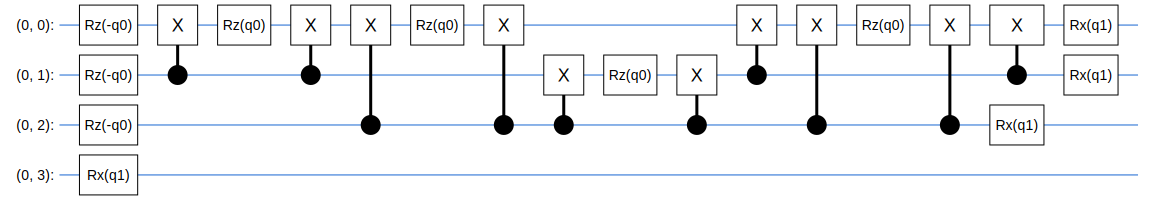

In [41]:
SVGCircuit(qaoa_circuit)